In [5]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from helpers.cm26 import DatasetCM26, read_datasets
from helpers.selectors import select_NA, select_Pacific, select_Cem, select_globe, compare, plot, select_ACC, select_Equator
from helpers.operators import Coarsen, Filtering, Subsampling, CoarsenKochkov, CoarsenWeighted, CoarsenKochkovMinMax
from helpers.state_functions import *

import hvplot.xarray
import hvplot
import cmocean

import matplotlib as mpl

%load_ext autoreload
%autoreload 3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
def read_skill(exp='EXP0', factors=[4,9,12,15]):
    ds = []
    for factor in factors:
        dataset = xr.open_dataset(f'/scratch/pp2681/mom6/CM26_ML_models/ocean3d/Gauss-FGR3/{exp}/skill-test/factor-{factor}.nc', chunks={'zl':1})
        ds.append(dataset)
    ds = xr.concat(ds, dim='factor')
    ds['factor'] = factors
    return ds

Text(0.5, 1.0, 'Model: ANN \n Data: trained at 4 coarse resolutions and 10 depths')

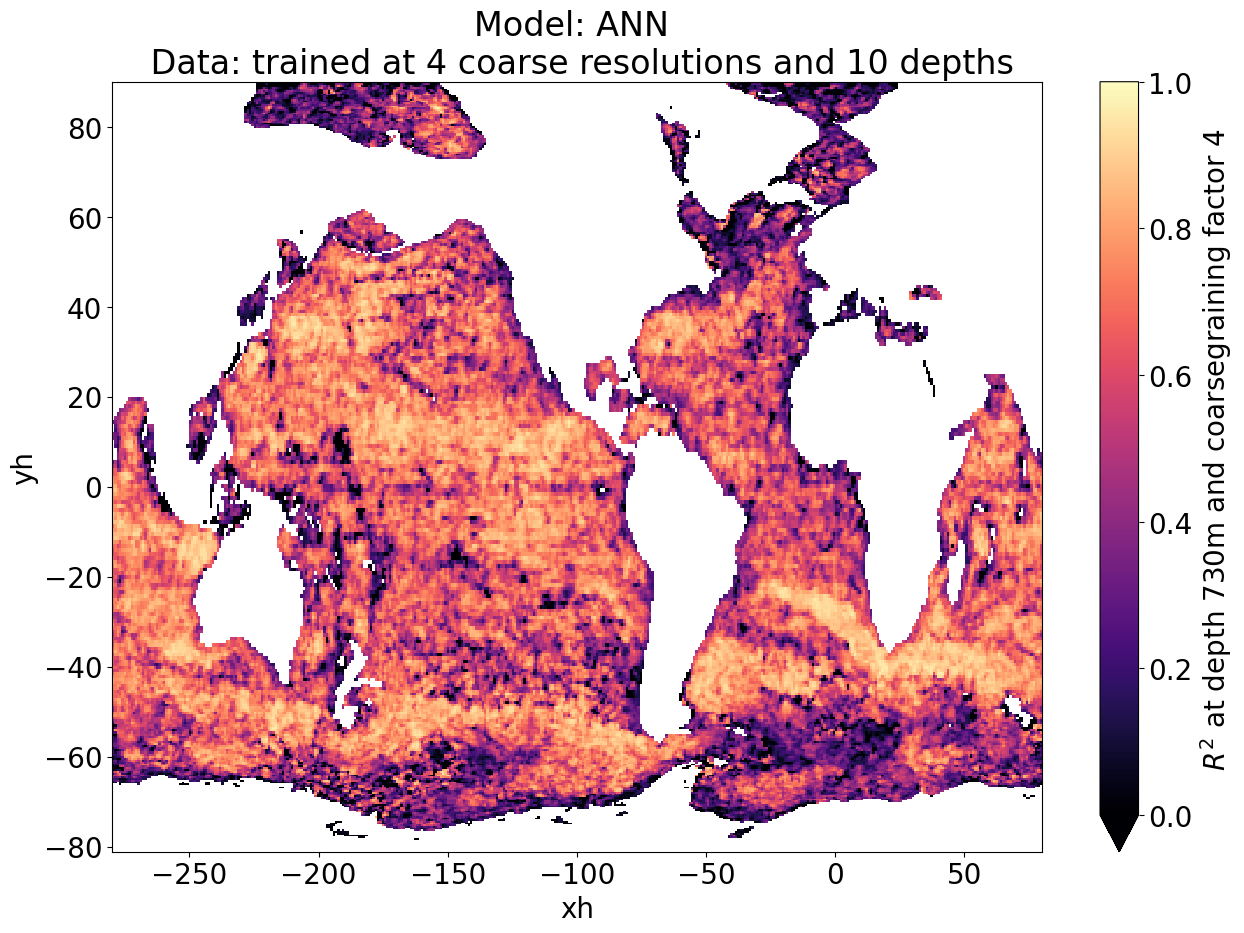

In [130]:
plt.figure(figsize=(15,10))
plt.rcParams['font.size'] = 20
read_skill('EXP-32-32/repeat', factors=[9]).R2_map.isel(zl=5).plot(vmax=1,vmin=0, cmap=mpl.cm.magma, cbar_kwargs={'label': '$R^2$ at depth 730m and coarsegraining factor 4'})
plt.title('Model: ANN \n Data: trained at 4 coarse resolutions and 10 depths')

Text(0.5, 1.0, 'Model: ANN with Ld/dx \n Data: trained at 4 coarse resolutions and 10 depths')

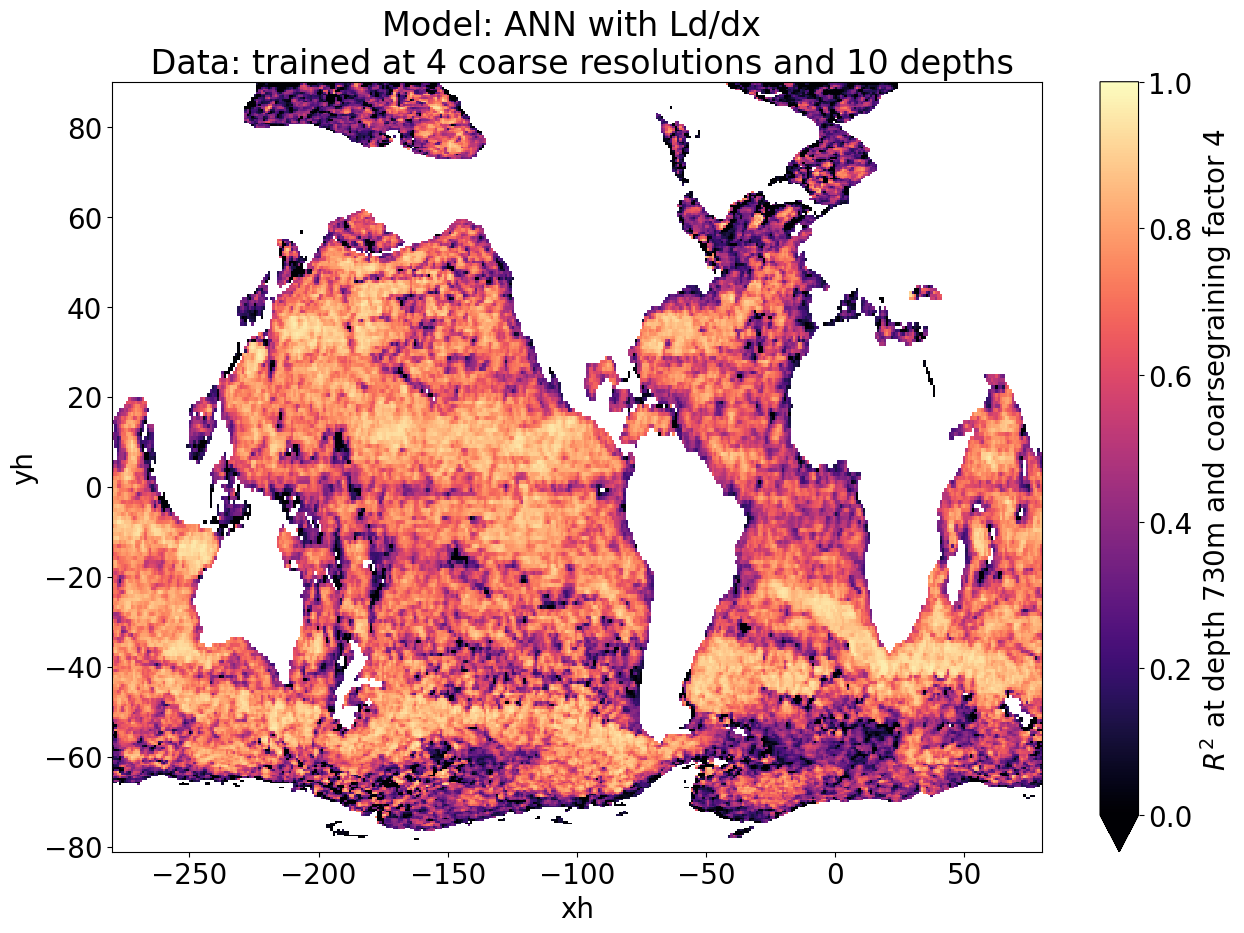

In [129]:
plt.figure(figsize=(15,10))
plt.rcParams['font.size'] = 20
read_skill('EXP-32-32/radius_over_grid_linear', factors=[9]).R2_map.isel(zl=5).plot(vmax=1,vmin=0, cmap=mpl.cm.magma, cbar_kwargs={'label': '$R^2$ at depth 730m and coarsegraining factor 4'})
plt.title('Model: ANN with Ld/dx \n Data: trained at 4 coarse resolutions and 10 depths')

In [7]:
import cmocean
def plot_metric(exp=None, metric='R2',vmin=0,vmax=1):
    exp[metric].drop_vars(['zl','factor']).plot(x='factor', y='zl',cmap=cmocean.cm.balance, vmin=vmin, vmax=vmax, cbar_kwargs={'label':''})
    plt.yticks(np.arange(10),[5, 55, 110, 180,330, 730,1500,2500,3500,4500]);
    plt.ylabel('Depth, m')
    plt.xticks(np.arange(4),[4,9,12,15]);
    if metric == 'R2':
        title_str = '$R^2$'
    elif metric == 'corr':
        title_str = 'Correlation'
    elif metric == 'opt_scaling':
        title_str = 'Optimal scaling'
    
    mean_val = float(exp[metric].mean())
    std_val = float(exp[metric].std())
    plt.title(metric+'\n [mean/std]=[%.3f,%.3f]' % (mean_val,std_val))
    
    plt.xlabel('Coarsegraining factor')
    plt.gca().invert_yaxis()

# 32x32 models

CPU times: user 1.17 s, sys: 58.7 ms, total: 1.23 s
Wall time: 2.99 s


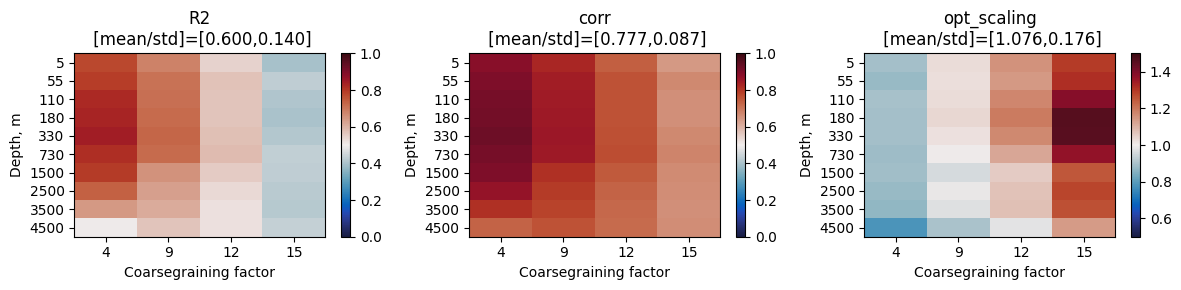

In [4]:
%time exp1 = read_skill('EXP1')
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plot_metric(exp1,'R2')
plt.subplot(1,3,2)
plot_metric(exp1,'corr')
plt.subplot(1,3,3)
plot_metric(exp1,'opt_scaling',vmin=0.5,vmax=1.5)
plt.tight_layout()

CPU times: user 1.15 s, sys: 36.2 ms, total: 1.18 s
Wall time: 2.35 s


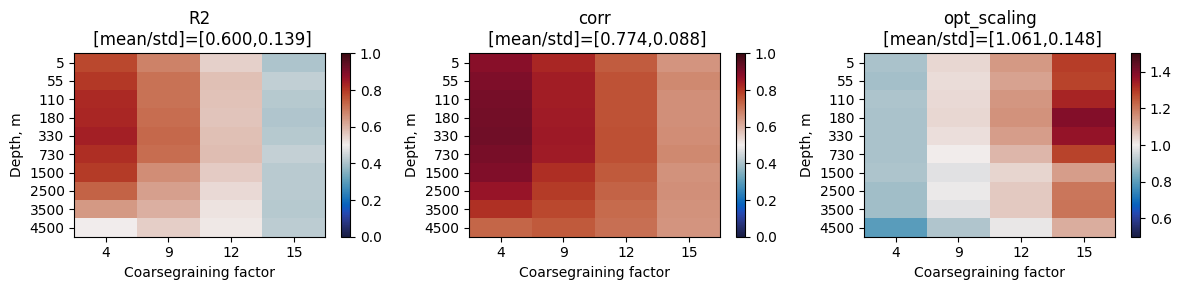

In [5]:
%time exp32 = read_skill('Collocated-NN-params/hdn-32-32')
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plot_metric(exp32,'R2')
plt.subplot(1,3,2)
plot_metric(exp32,'corr')
plt.subplot(1,3,3)
plot_metric(exp32,'opt_scaling',vmin=0.5,vmax=1.5)
plt.tight_layout()

CPU times: user 1.14 s, sys: 35.8 ms, total: 1.18 s
Wall time: 1.32 s


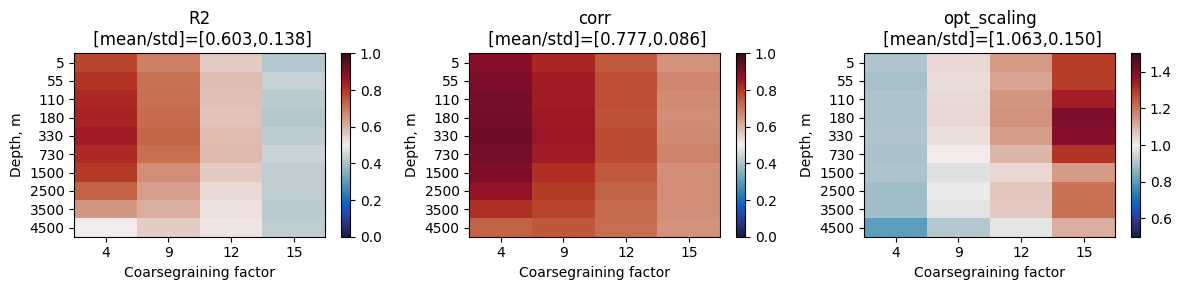

In [10]:
%time exp_32 = read_skill('EXP-32-32/repeat')
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plot_metric(exp_32,'R2')
plt.subplot(1,3,2)
plot_metric(exp_32,'corr')
plt.subplot(1,3,3)
plot_metric(exp_32,'opt_scaling',vmin=0.5,vmax=1.5)
plt.tight_layout()

CPU times: user 958 ms, sys: 29.9 ms, total: 988 ms
Wall time: 1.14 s


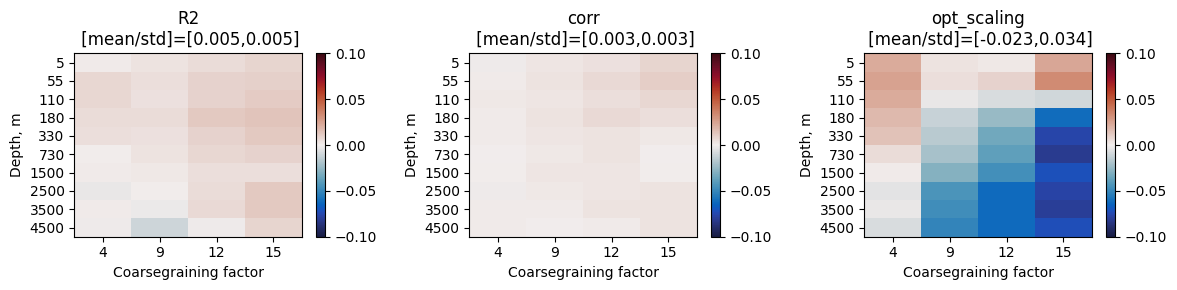

In [15]:
%time exp = read_skill('EXP-32-32/radius_over_grid_linear')
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plot_metric(exp-exp_32,'R2',vmin=-0.1,vmax=0.1)
plt.subplot(1,3,2)
plot_metric(exp-exp_32,'corr',vmin=-0.1,vmax=0.1)
plt.subplot(1,3,3)
plot_metric(exp-exp_32,'opt_scaling',vmin=-0.1,vmax=0.1)
plt.tight_layout()

CPU times: user 977 ms, sys: 28.1 ms, total: 1.01 s
Wall time: 4.68 s


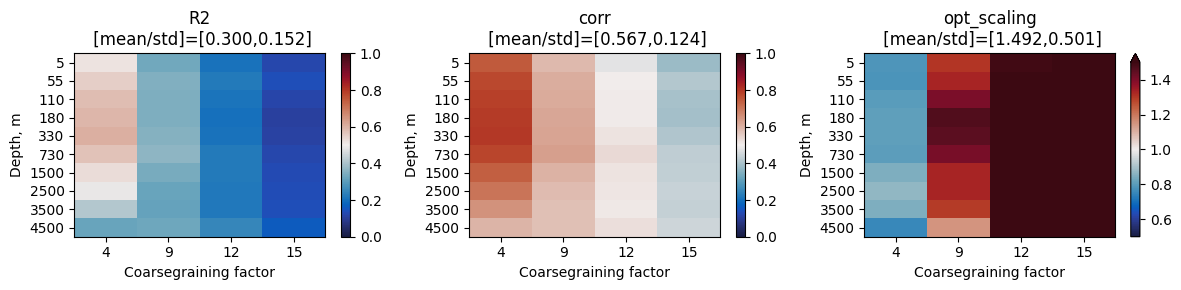

In [16]:
%time exp = read_skill('EXP-32-32/1x1')
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plot_metric(exp,'R2')
plt.subplot(1,3,2)
plot_metric(exp,'corr')
plt.subplot(1,3,3)
plot_metric(exp,'opt_scaling',vmin=0.5,vmax=1.5)
plt.tight_layout()

CPU times: user 961 ms, sys: 36.6 ms, total: 997 ms
Wall time: 3.34 s


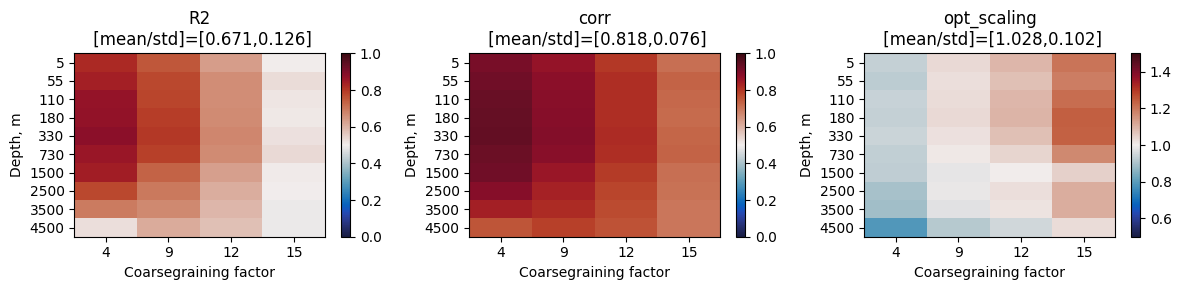

In [17]:
%time exp = read_skill('EXP-32-32/5x5')
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plot_metric(exp,'R2')
plt.subplot(1,3,2)
plot_metric(exp,'corr')
plt.subplot(1,3,3)
plot_metric(exp,'opt_scaling',vmin=0.5,vmax=1.5)
plt.tight_layout()

CPU times: user 948 ms, sys: 27.8 ms, total: 976 ms
Wall time: 1.06 s


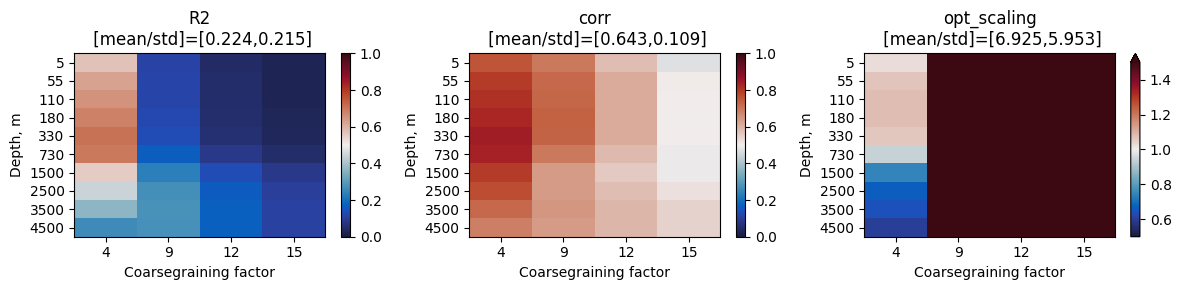

In [19]:
%time exp = read_skill('EXP-32-32/ANN')
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plot_metric(exp,'R2')
plt.subplot(1,3,2)
plot_metric(exp,'corr')
plt.subplot(1,3,3)
plot_metric(exp,'opt_scaling',vmin=0.5,vmax=1.5)
plt.tight_layout()

# 64-64 models

CPU times: user 953 ms, sys: 31.7 ms, total: 985 ms
Wall time: 3.97 s


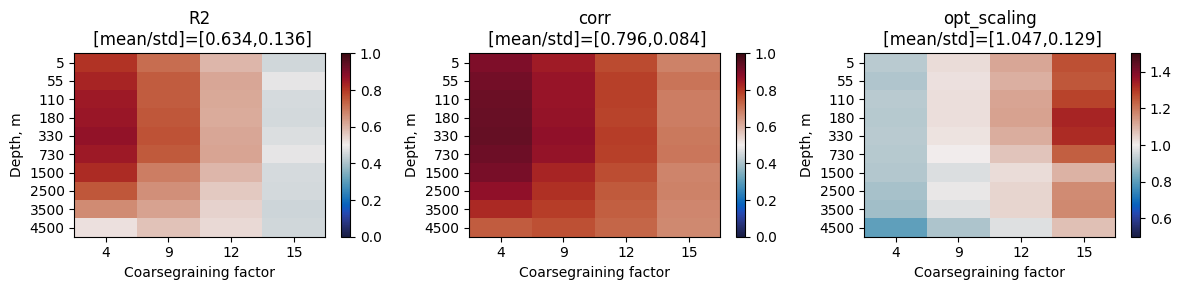

In [20]:
%time exp64 = read_skill('Collocated-NN-params/hdn-64-64')
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plot_metric(exp64,'R2')
plt.subplot(1,3,2)
plot_metric(exp64,'corr')
plt.subplot(1,3,3)
plot_metric(exp64,'opt_scaling',vmin=0.5,vmax=1.5)
plt.tight_layout()

CPU times: user 996 ms, sys: 31.8 ms, total: 1.03 s
Wall time: 3.95 s


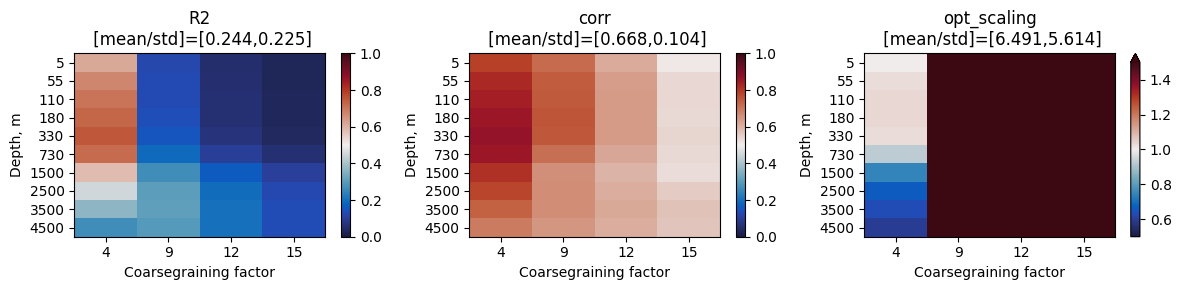

In [32]:
%time exp = read_skill('EXP-64-64/ANN')
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plot_metric(exp,'R2')
plt.subplot(1,3,2)
plot_metric(exp,'corr')
plt.subplot(1,3,3)
plot_metric(exp,'opt_scaling',vmin=0.5,vmax=1.5)
plt.tight_layout()

CPU times: user 1.5 s, sys: 56 ms, total: 1.55 s
Wall time: 2.89 s


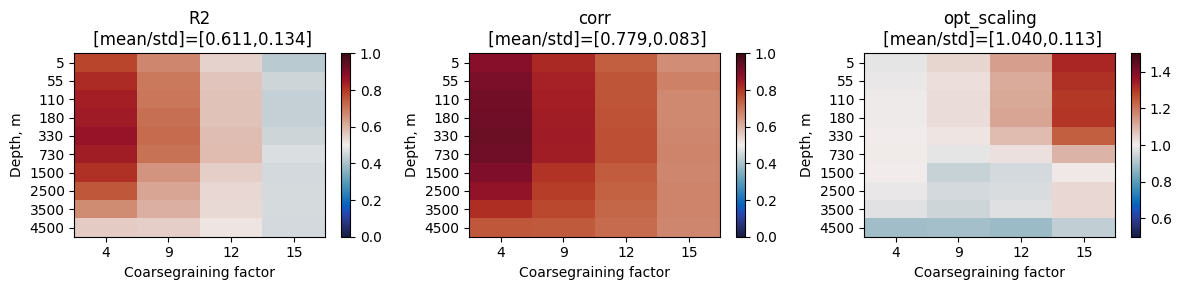

In [10]:
%time exp = read_skill('EXP-64-64/grid_step')
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plot_metric(exp,'R2')
plt.subplot(1,3,2)
plot_metric(exp,'corr')
plt.subplot(1,3,3)
plot_metric(exp,'opt_scaling',vmin=0.5,vmax=1.5)
plt.tight_layout()

CPU times: user 1.22 s, sys: 39.9 ms, total: 1.26 s
Wall time: 1.49 s


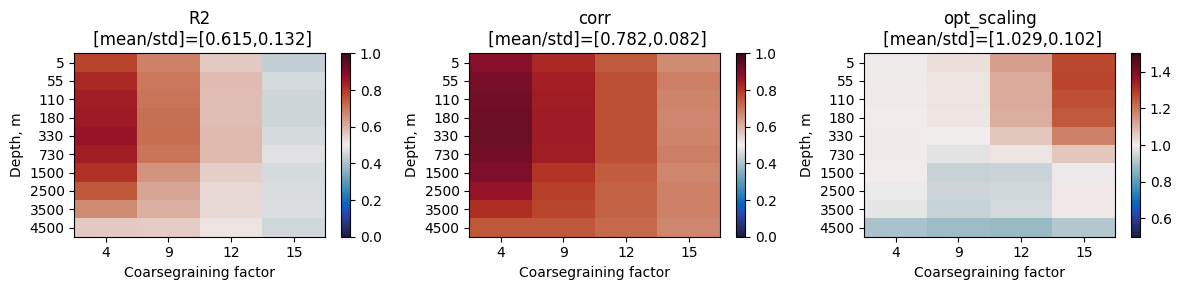

In [22]:
%time exp = read_skill('EXP-64-64/step-radius')
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plot_metric(exp,'R2')
plt.subplot(1,3,2)
plot_metric(exp,'corr')
plt.subplot(1,3,3)
plot_metric(exp,'opt_scaling',vmin=0.5,vmax=1.5)
plt.tight_layout()

CPU times: user 973 ms, sys: 33.7 ms, total: 1.01 s
Wall time: 4.58 s


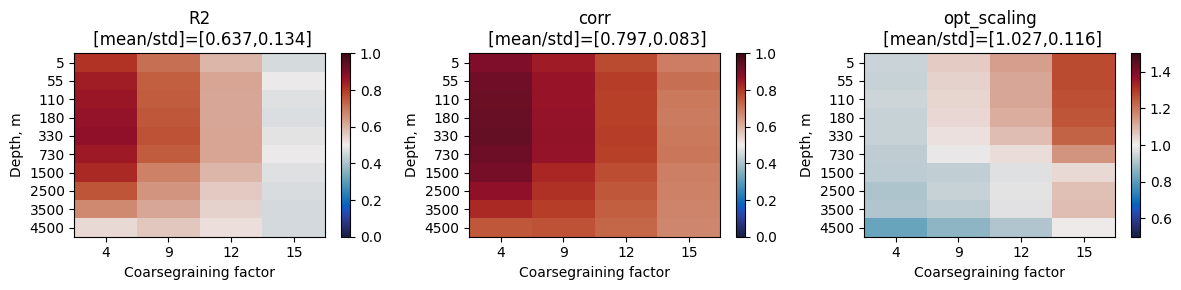

In [23]:
%time exp = read_skill('EXP-64-64/radius_over_grid')
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plot_metric(exp,'R2')
plt.subplot(1,3,2)
plot_metric(exp,'corr')
plt.subplot(1,3,3)
plot_metric(exp,'opt_scaling',vmin=0.5,vmax=1.5)
plt.tight_layout()

CPU times: user 1.24 s, sys: 56.6 ms, total: 1.29 s
Wall time: 3.7 s


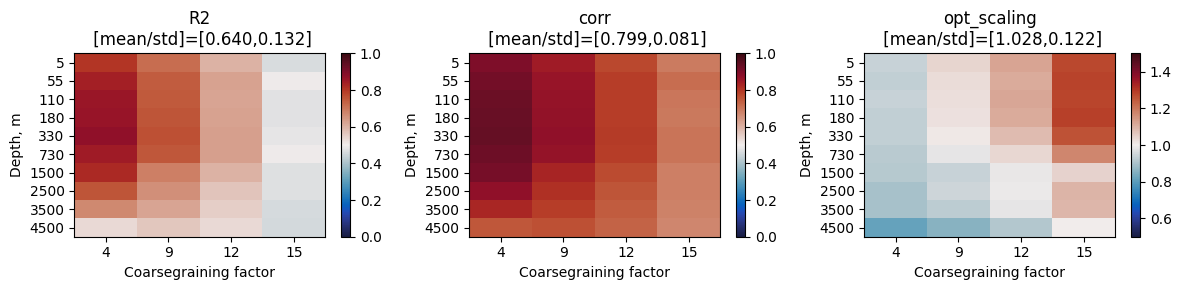

In [25]:
%time exp = read_skill('EXP-64-64/radius_over_grid_linear')
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plot_metric(exp,'R2')
plt.subplot(1,3,2)
plot_metric(exp,'corr')
plt.subplot(1,3,3)
plot_metric(exp,'opt_scaling',vmin=0.5,vmax=1.5)
plt.tight_layout()

CPU times: user 1.01 s, sys: 27.6 ms, total: 1.04 s
Wall time: 4.1 s


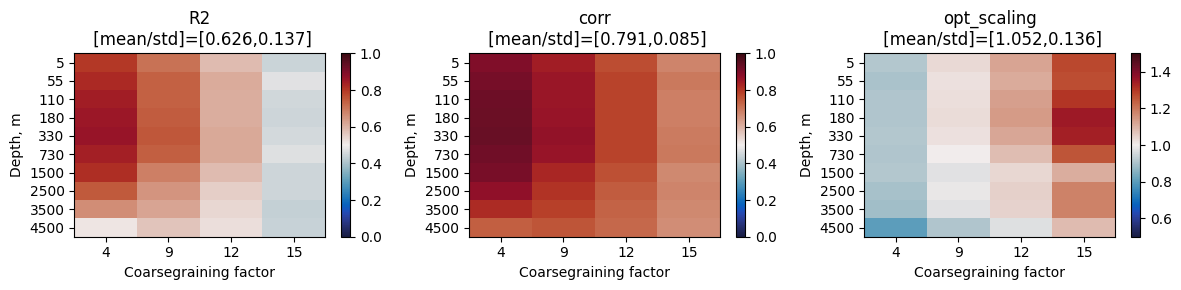

In [26]:
%time exp = read_skill('EXP-64-64/radius')
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plot_metric(exp,'R2')
plt.subplot(1,3,2)
plot_metric(exp,'corr')
plt.subplot(1,3,3)
plot_metric(exp,'opt_scaling',vmin=0.5,vmax=1.5)
plt.tight_layout()

CPU times: user 1.02 s, sys: 28.8 ms, total: 1.05 s
Wall time: 3.59 s


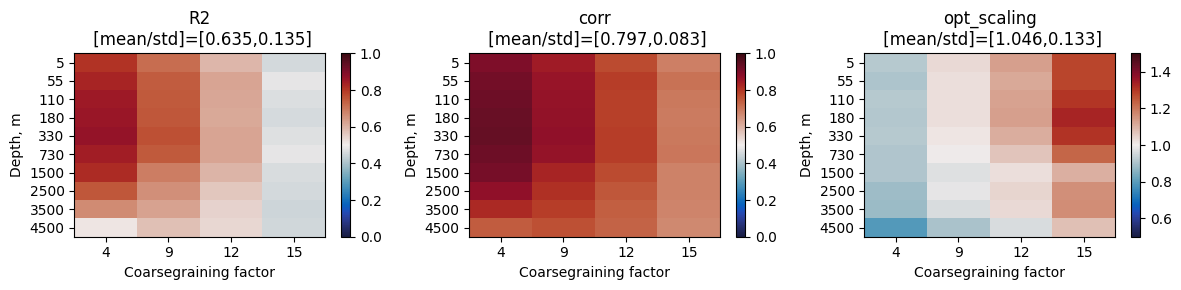

In [27]:
%time exp = read_skill('EXP-64-64/radius_linear')
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plot_metric(exp,'R2')
plt.subplot(1,3,2)
plot_metric(exp,'corr')
plt.subplot(1,3,3)
plot_metric(exp,'opt_scaling',vmin=0.5,vmax=1.5)
plt.tight_layout()

CPU times: user 1.23 s, sys: 59.8 ms, total: 1.29 s
Wall time: 3.34 s


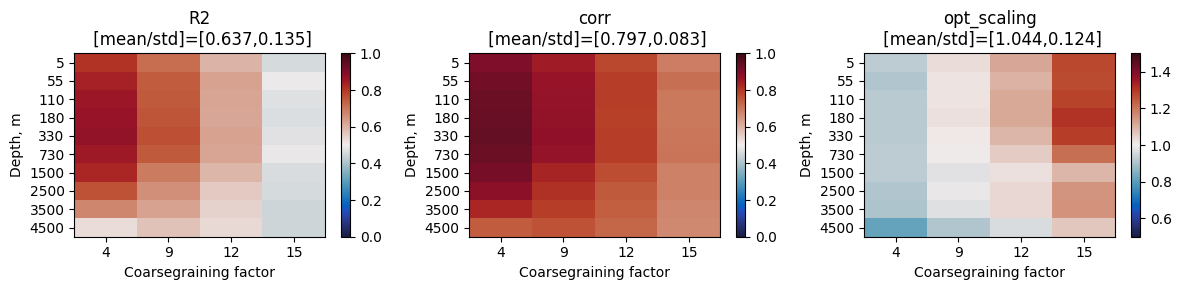

In [28]:
%time exp = read_skill('EXP-64-64/Held_Larichev_1996')
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plot_metric(exp,'R2')
plt.subplot(1,3,2)
plot_metric(exp,'corr')
plt.subplot(1,3,3)
plot_metric(exp,'opt_scaling',vmin=0.5,vmax=1.5)
plt.tight_layout()

CPU times: user 982 ms, sys: 31.8 ms, total: 1.01 s
Wall time: 3.23 s


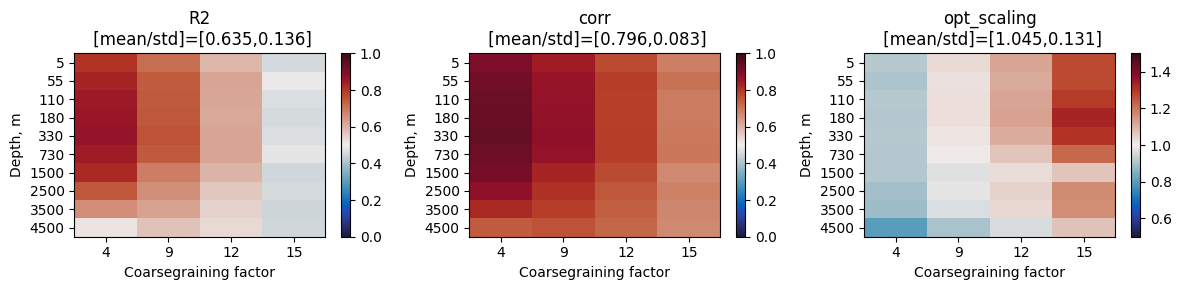

In [29]:
%time exp = read_skill('EXP-64-64/Held_Larichev_1996_linear')
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plot_metric(exp,'R2')
plt.subplot(1,3,2)
plot_metric(exp,'corr')
plt.subplot(1,3,3)
plot_metric(exp,'opt_scaling',vmin=0.5,vmax=1.5)
plt.tight_layout()

CPU times: user 964 ms, sys: 31.8 ms, total: 996 ms
Wall time: 3.67 s


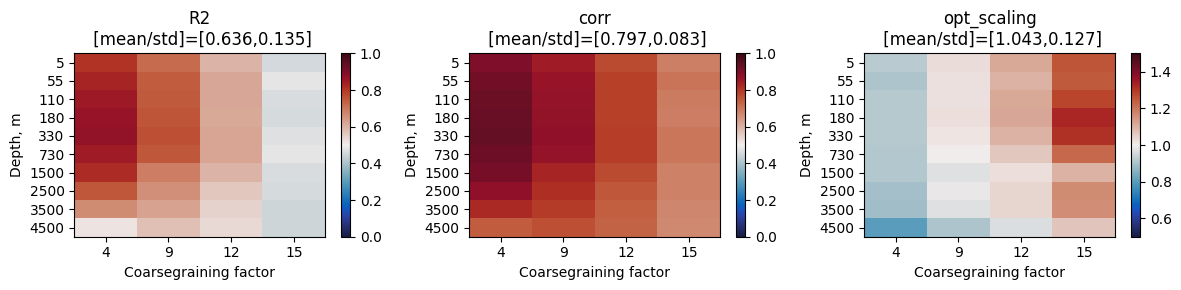

In [30]:
%time exp = read_skill('EXP-64-64/Held_Larichev_1996_linear_inverse')
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plot_metric(exp,'R2')
plt.subplot(1,3,2)
plot_metric(exp,'corr')
plt.subplot(1,3,3)
plot_metric(exp,'opt_scaling',vmin=0.5,vmax=1.5)
plt.tight_layout()

CPU times: user 1.2 s, sys: 30.7 ms, total: 1.23 s
Wall time: 3.5 s


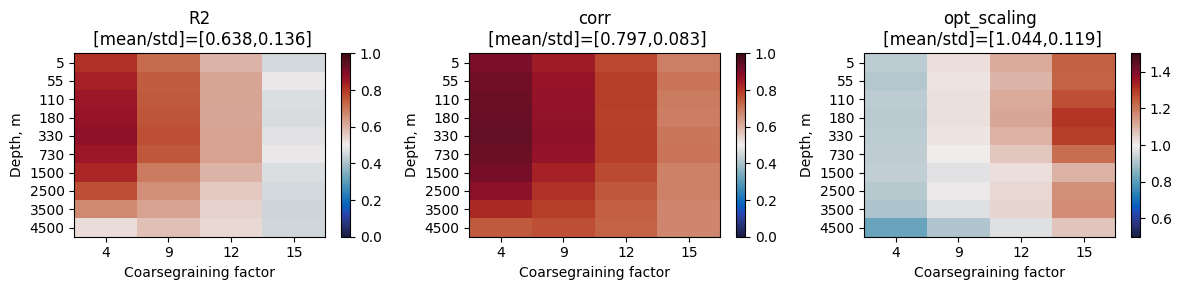

In [31]:
%time exp = read_skill('EXP-64-64/Held_Larichev_1996_linear_inverse_range')
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plot_metric(exp,'R2')
plt.subplot(1,3,2)
plot_metric(exp,'corr')
plt.subplot(1,3,3)
plot_metric(exp,'opt_scaling',vmin=0.5,vmax=1.5)
plt.tight_layout()

# Summary
* Restriction stencil to 1x1 considerably restricts the performance
* Extending stencil to 5x5 considerably improves the performance
* ANN without dimensional scaling does not generalize
* ANN with the grid step as input feature performs much better than without dimensional scaling but worse than the dimensional scaling
* (dx,Ld) is less efficient than the dimensional scaling + (Ld/dx)
* Linear feature (Ld/dx) is better than logarithm
* Profit of Held Larichev is unclear

# Feature distributions once again

In [20]:
from helpers.feature_extractors import *

In [21]:
ds = read_datasets(['test'], [4,15])

Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-4
Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-15


In [22]:
ds4 = ds['test-4'].select2d(zl=0)
ds15 = ds['test-15'].select2d(zl=0)

In [23]:
def plot_hist(function):
    plt.figure(figsize=(12,10))
    plt.subplot(2,2,1)
    plt.hist(ds4.nanvar(function(ds4)[0]).values.ravel(),100);
    plt.subplot(2,2,2)
    plt.hist(ds4.nanvar(function(ds4)[1]).values.ravel(),100);
    plt.subplot(2,2,3)
    plt.hist(ds15.nanvar(function(ds15)[1]).values.ravel(),100);
    plt.subplot(2,2,4)
    plt.hist(ds15.nanvar(function(ds15)[1]).values.ravel(),100);

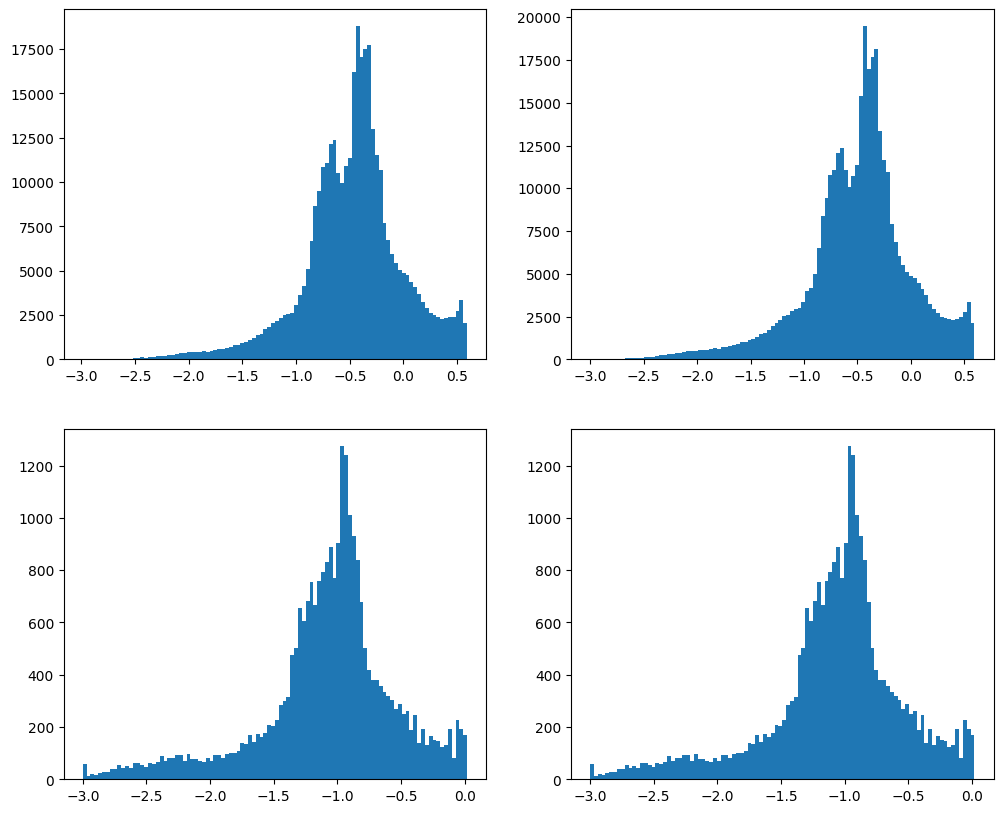

In [24]:
plot_hist(deformation_radius_over_grid_spacing)

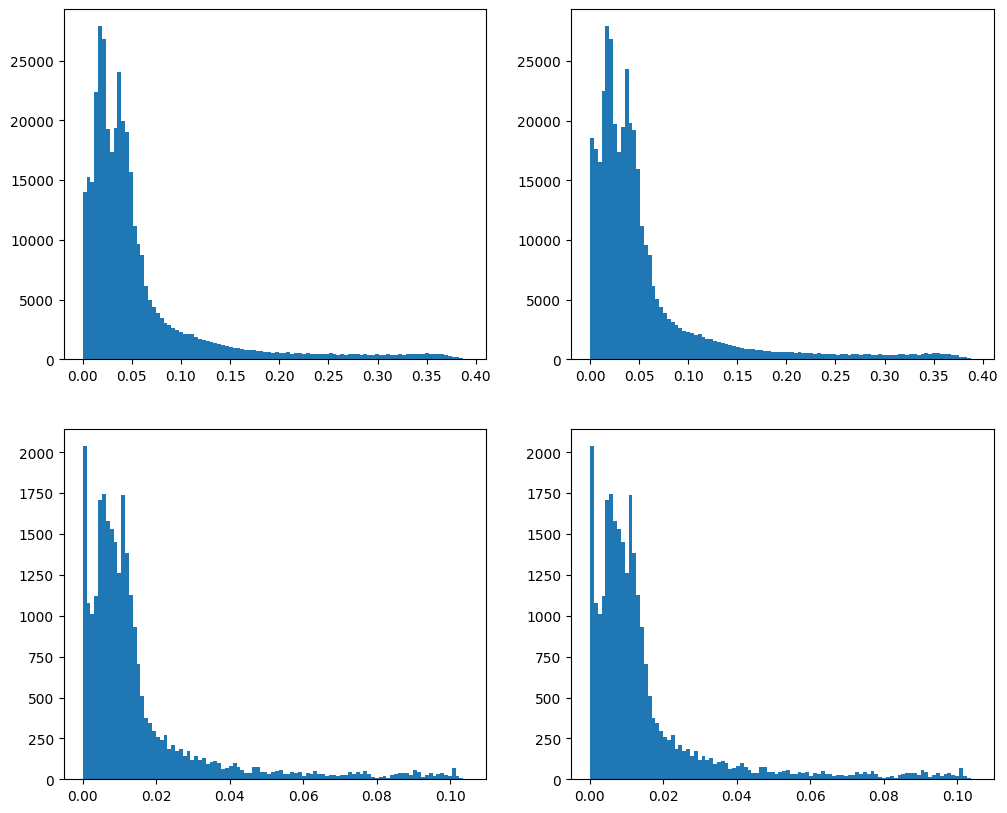

In [25]:
plot_hist(deformation_radius_over_grid_spacing_linear)

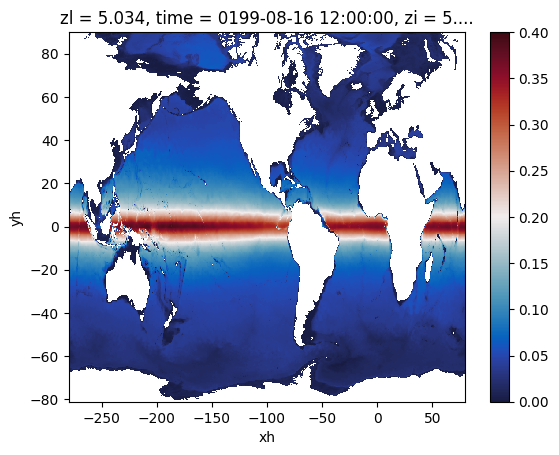

In [44]:
ds4.nanvar(deformation_radius_over_grid_spacing_linear(ds4)[1]).plot(vmin=0,vmax=0.4,cmap=cmocean.cm.balance)

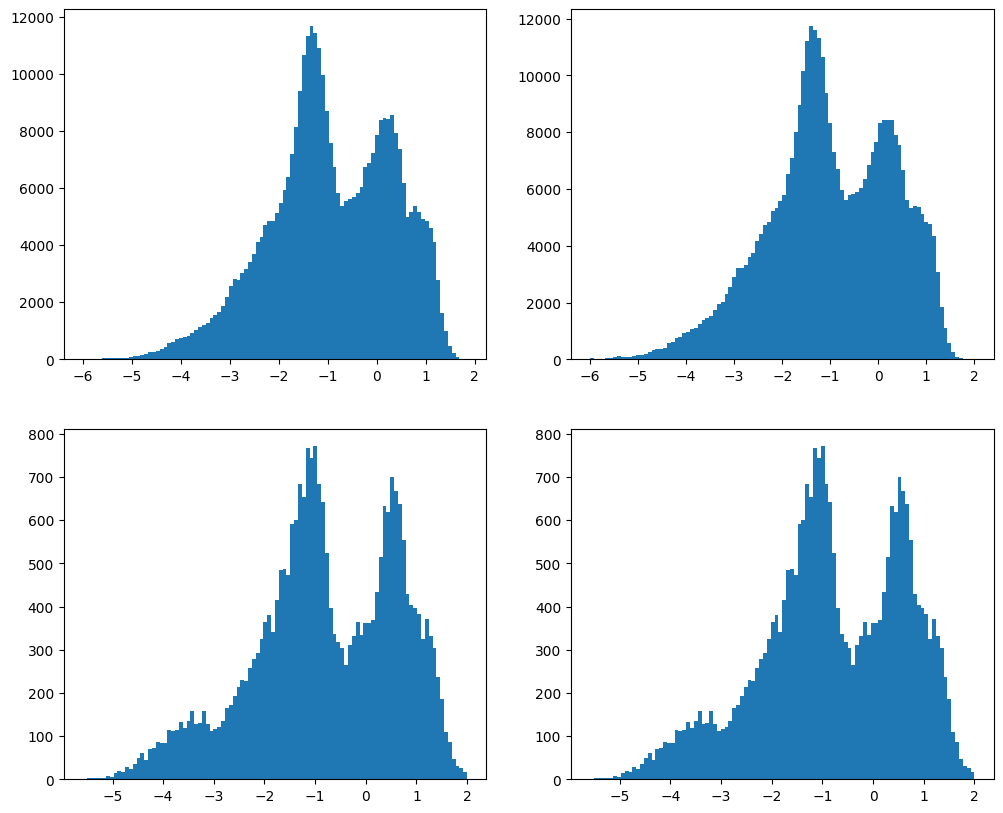

In [45]:
plot_hist(Held_Larichev_1996)

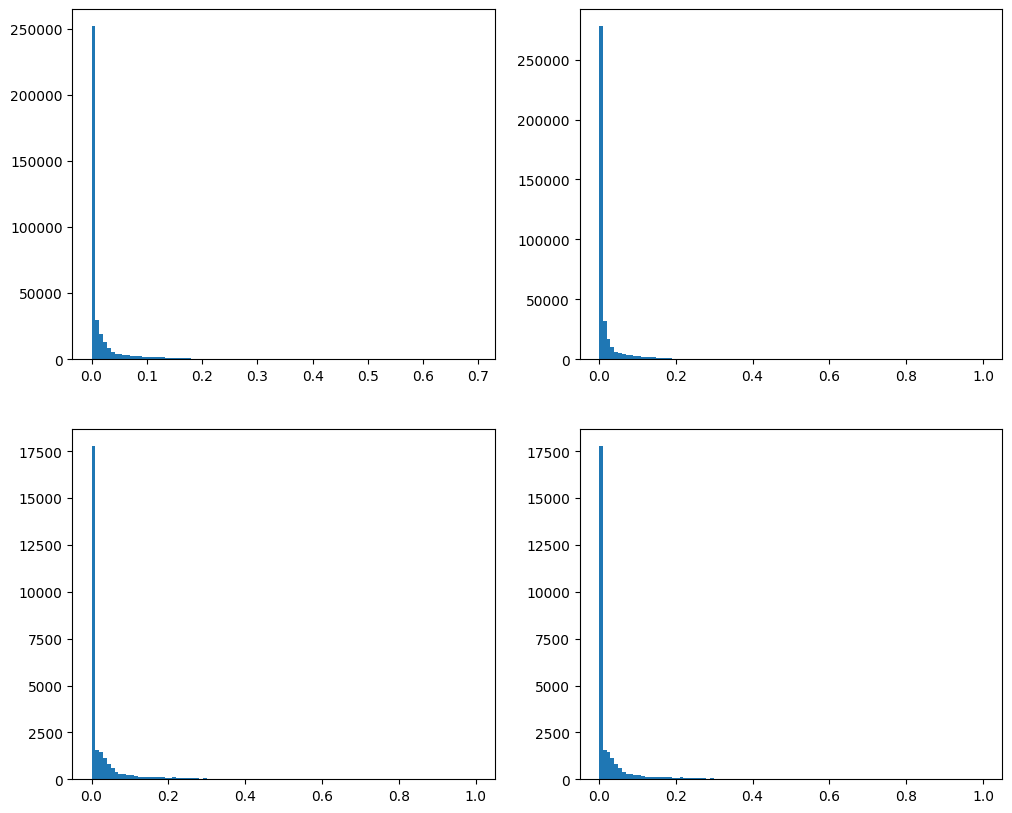

In [84]:
plot_hist(Held_Larichev_1996_linear)

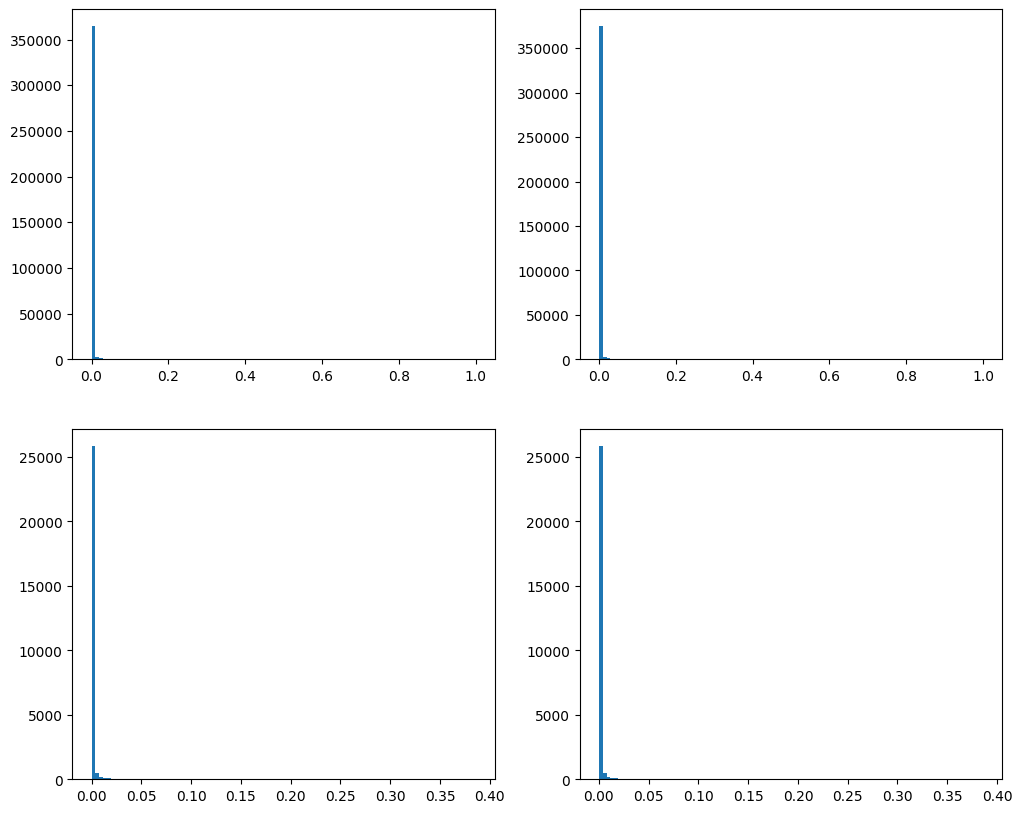

In [120]:
plot_hist(Held_Larichev_1996_linear_inverse)

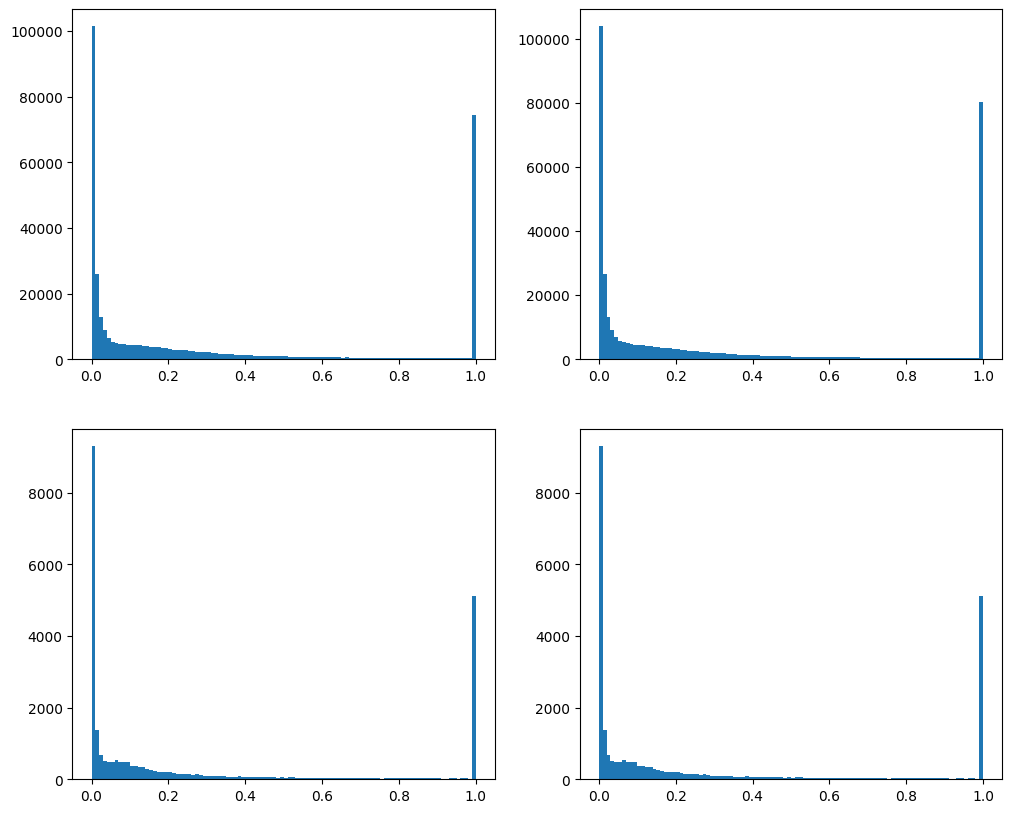

In [121]:
plot_hist(Held_Larichev_1996_linear_inverse_range)

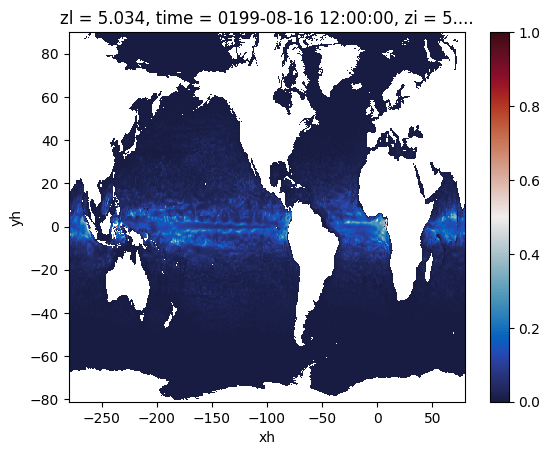

In [85]:
ds4.nanvar(Held_Larichev_1996_linear(ds4)[1]).plot(cmap=cmocean.cm.balance)

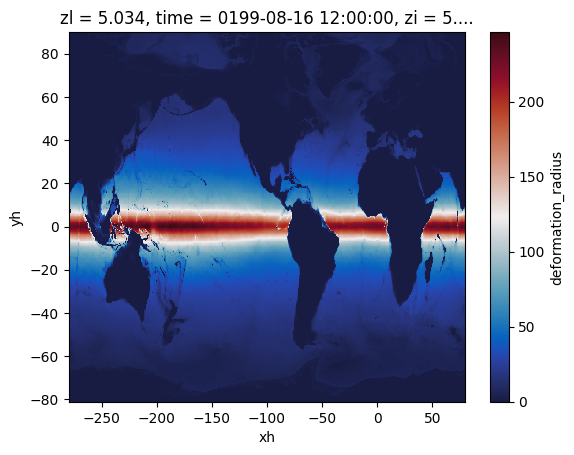

In [60]:
(ds4.data.deformation_radius/1e+3).plot(cmap=cmocean.cm.balance)

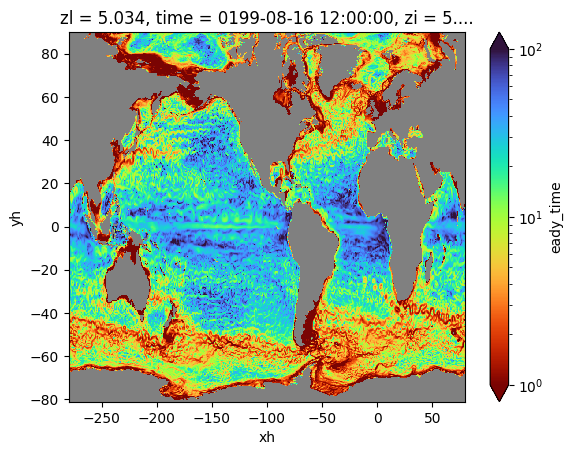

In [66]:
cmap = mpl.cm.turbo.reversed()
cmap.set_bad('gray')
ds4.nanvar(ds4.data.eady_time/86400).plot(norm=mpl.colors.LogNorm(vmax=100, vmin=1), cmap=cmap)

In [68]:
f, beta = Coriolis(ds4.data.yh,compute_beta=True)

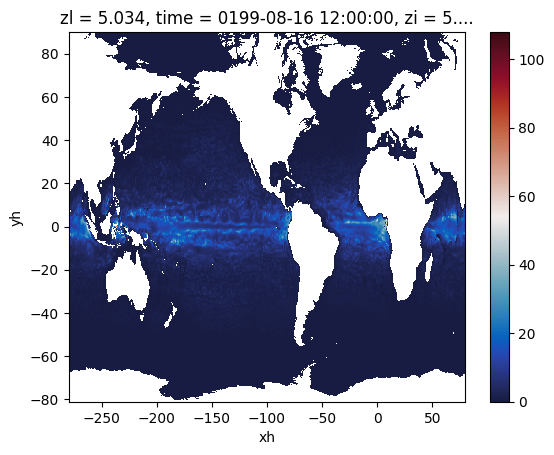

In [115]:
ds4.nanvar(beta * ds4.data.deformation_radius * ds4.data.eady_time).plot(cmap=cmocean.cm.balance)

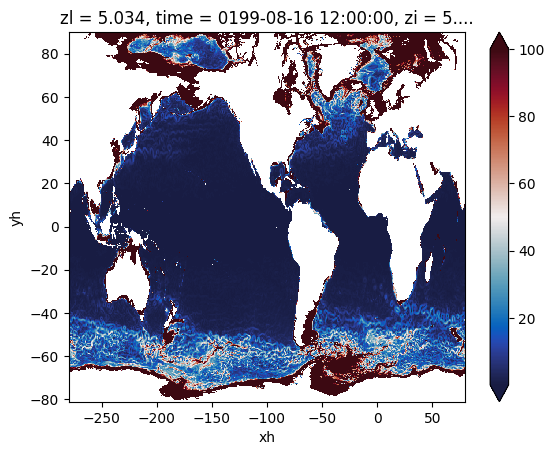

In [119]:
ds4.nanvar(1/ (beta * ds4.data.deformation_radius * ds4.data.eady_time)).plot(cmap=cmocean.cm.balance,vmax=100,robust=True)

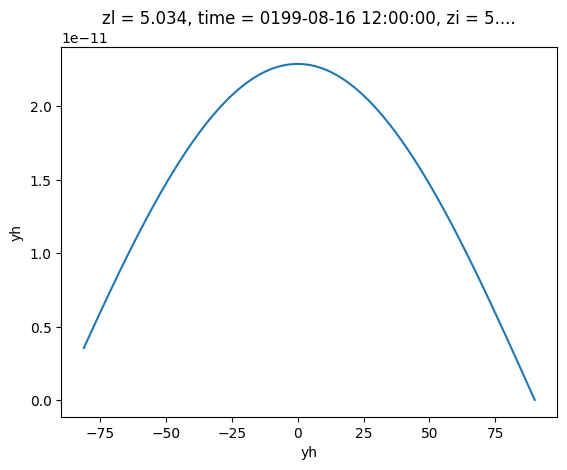

In [69]:
beta.plot()

In [70]:
100*86400 * 200e+3 * 2e-11

34.559999999999995

In [72]:
Held_Larichev_1996(ds4)[1].max().values

array(2.)

In [86]:
sh_xy, sh_xx, vort_xy, _ = ds4.state.velocity_gradients()
grid = ds4.grid
param = ds4.param

# In center point
Shear_mag = param.wet * (sh_xx**2+grid.interp(sh_xy**2,['X','Y']))**0.5

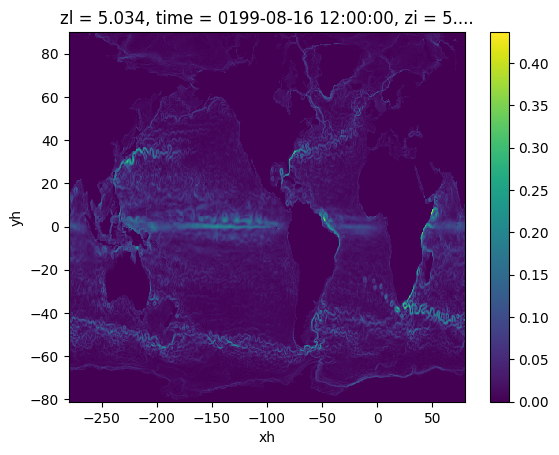

In [104]:
deltaU = ds4.data.deformation_radius / ds4.data.eady_time
deltaU.plot()

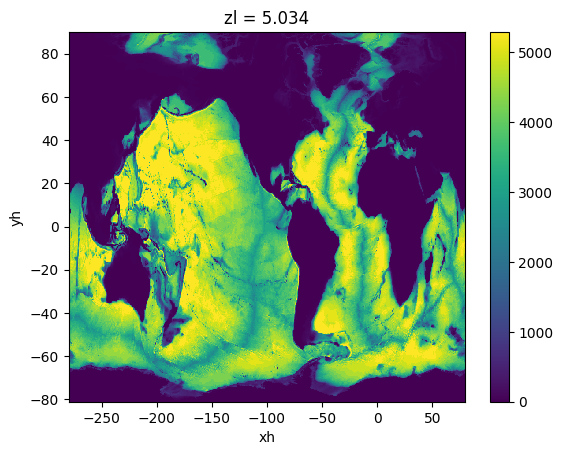

In [103]:
H = (param.zi * param.wet_w).max('zi')
H.plot()

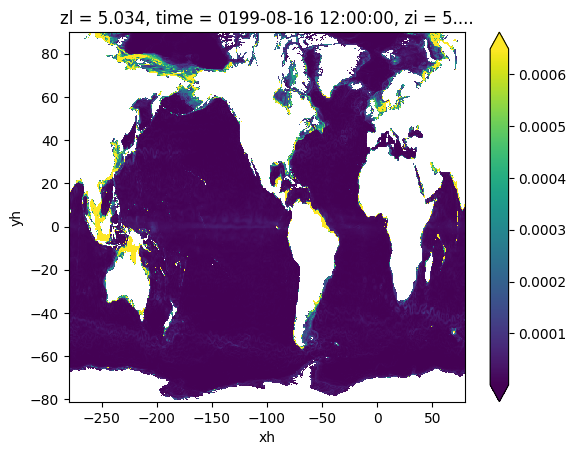

In [106]:
dudz = deltaU / H
dudz.plot(robust=True)

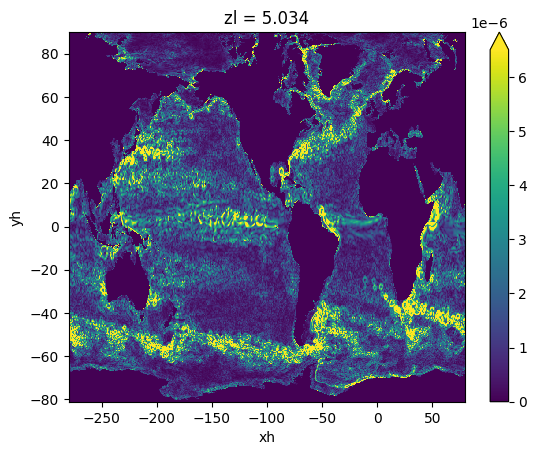

In [107]:
Shear_mag.plot(robust=True)

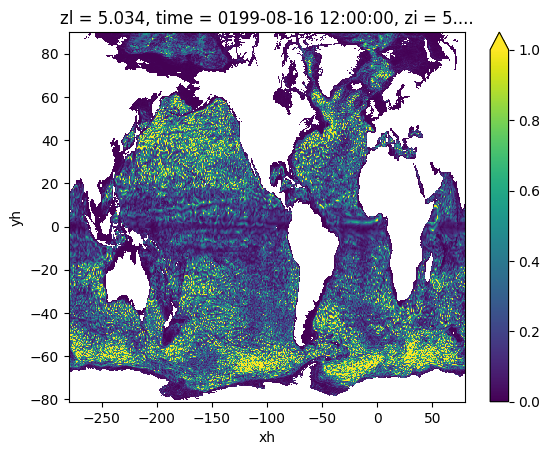

In [110]:
(Shear_mag/dudz).plot(vmax=1)

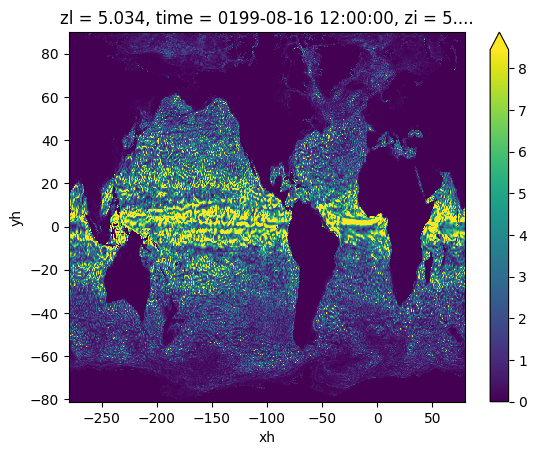

In [114]:
(Shear_mag * ds4.data.eady_time).plot(robust=True)

# Change in PDF? 

In [4]:
ds = read_datasets(['test'], factors=[4,9,12,15])

Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-4
Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-9
Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-12
Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-15


In [5]:
from helpers.ann_tools import import_ANN
from helpers.feature_extractors import *

In [6]:
Tall = import_ANN('/scratch/pp2681/mom6/CM26_ML_models/ocean3d/Gauss-FGR3/EXP-32-32/radius_over_grid_linear/model/Tall.nc')
pred = ds['test-4'].select2d(zl=5,time=12).state.ANN(None,None,Tall,feature_functions=[deformation_radius_over_grid_spacing_linear], gradient_features=['sh_xy', 'sh_xx', 'rel_vort'], )

In [7]:
features = pred['feature_statistics']['features']
targets = pred['feature_statistics']['targets']

In [85]:
Tall_log = import_ANN('/scratch/pp2681/mom6/CM26_ML_models/ocean3d/Gauss-FGR3/EXP-32-32/radius_over_grid/model/Tall.nc')
pred_log = ds['test-15'].select2d(zl=5,time=12).state.ANN(None,None,Tall_log,feature_functions=[deformation_radius_over_grid_spacing], gradient_features=['sh_xy', 'sh_xx', 'rel_vort'], )

In [87]:
features_log = pred_log['feature_statistics']['features']
targets_log = pred_log['feature_statistics']['targets']

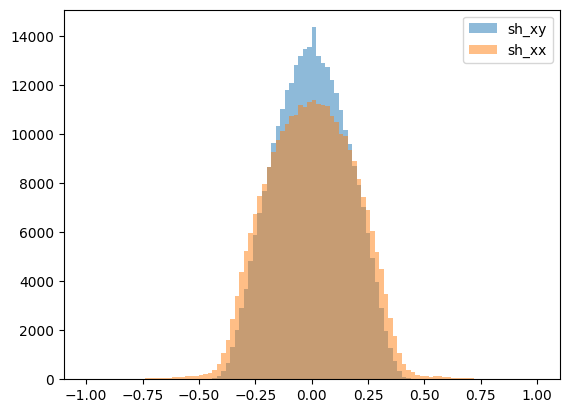

In [160]:
plt.hist(features[:,4],100,alpha=0.5,label='sh_xy',range=[-1,1]);
plt.hist(features[:,4+9],100,alpha=0.5,label='sh_xx',range=[-1,1]);
#plt.hist(features[:,4+9*2],100,alpha=0.5,label='rel_vort',range=[-1,1]);
#plt.hist(features[:,-1],100,alpha=0.5,label='$R_d/\Delta x$',range=[-1,1]);
plt.legend()

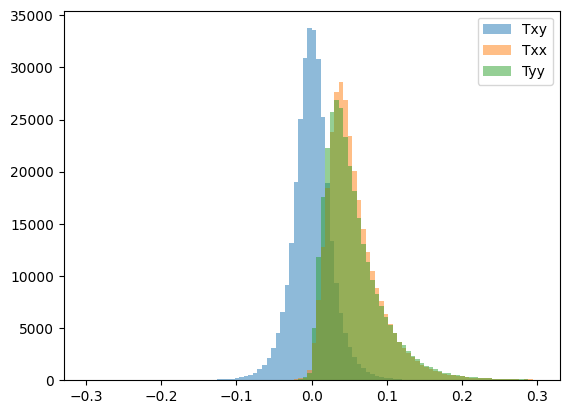

In [161]:
plt.hist(targets[:,0],100,alpha=0.5,label='Txy',range=[-0.3,0.3]);
plt.hist(targets[:,1],100,alpha=0.5,label='Txx',range=[-0.3,0.3]);
plt.hist(targets[:,2],100,alpha=0.5,label='Tyy',range=[-0.3,0.3]);
plt.legend()

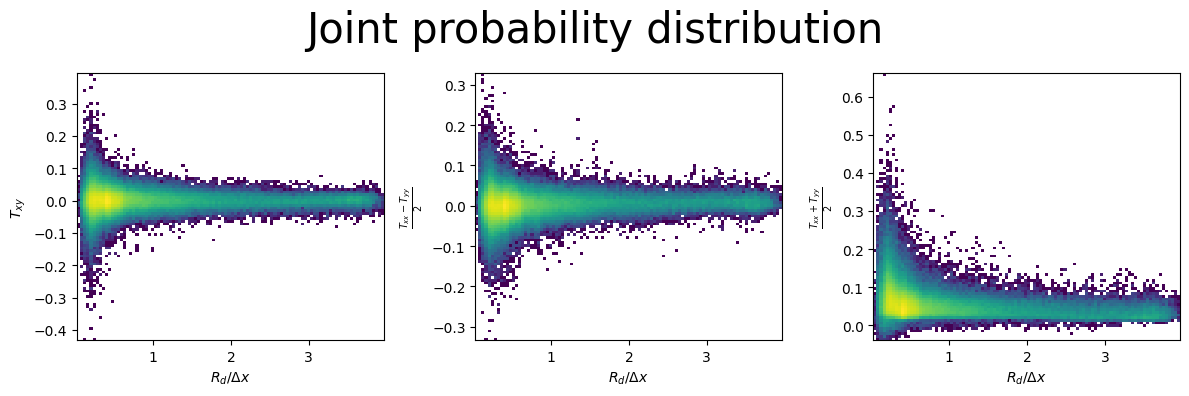

In [15]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.hist2d(features[:,-1]*10, targets[:,0], bins=100, norm=mpl.colors.LogNorm());
plt.ylabel('$T_{xy}$')
plt.xlabel('$R_d/\Delta x$')

plt.subplot(1,3,2)
plt.hist2d(features[:,-1]*10, (targets[:,1]-targets[:,2])*0.5, bins=100, norm=mpl.colors.LogNorm());
plt.ylabel('$\\frac{T_{xx}-T_{yy}}{2}$')
plt.xlabel('$R_d/\Delta x$')

plt.subplot(1,3,3)
plt.hist2d(features[:,-1]*10, (targets[:,1]+targets[:,2])*0.5, bins=100, norm=mpl.colors.LogNorm());
plt.ylabel('$\\frac{T_{xx}+T_{yy}}{2}$')
plt.xlabel('$R_d/\Delta x$')

plt.suptitle('Joint probability distribution', fontsize=30)
plt.tight_layout()

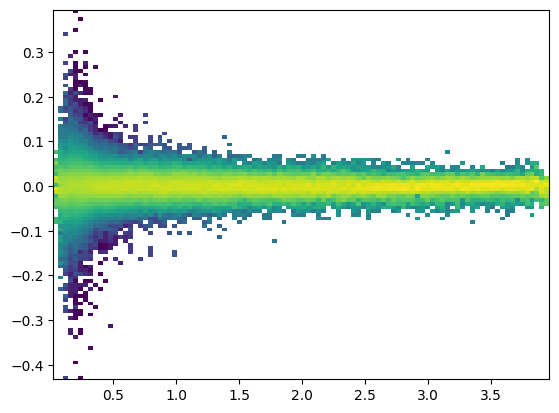

In [72]:
# plt.figure(figsize=(12,4))
# plt.subplot(1,3,1)
H, yedges, xedges = np.histogram2d(targets[:,0], features[:,-1]*10, bins=[100,100])
# Conditioning
H = H / H.sum(0)
plt.pcolormesh(xedges, yedges, H, norm=mpl.colors.LogNorm())

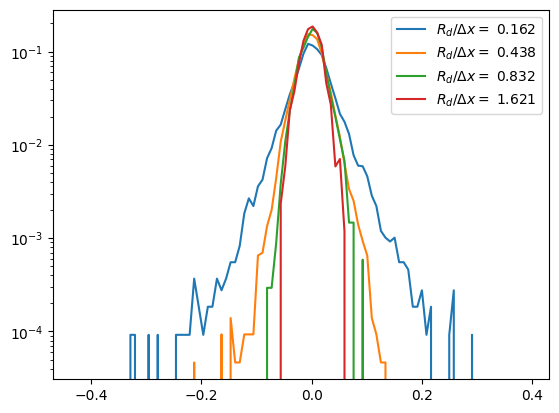

In [81]:
ycenters = (yedges[1:]+yedges[:-1])*0.5
xcenters = (xedges[1:]+xedges[:-1])*0.5
plt.semilogy(ycenters, H[:,3], label='$R_d/\Delta x =$ %.3f' % xcenters[3])
plt.semilogy(ycenters, H[:,10], label='$R_d/\Delta x =$ %.3f' % xcenters[10])
plt.semilogy(ycenters, H[:,20], label='$R_d/\Delta x =$ %.3f' % xcenters[20])
plt.semilogy(ycenters, H[:,40], label='$R_d/\Delta x =$ %.3f' % xcenters[40])
plt.legend()

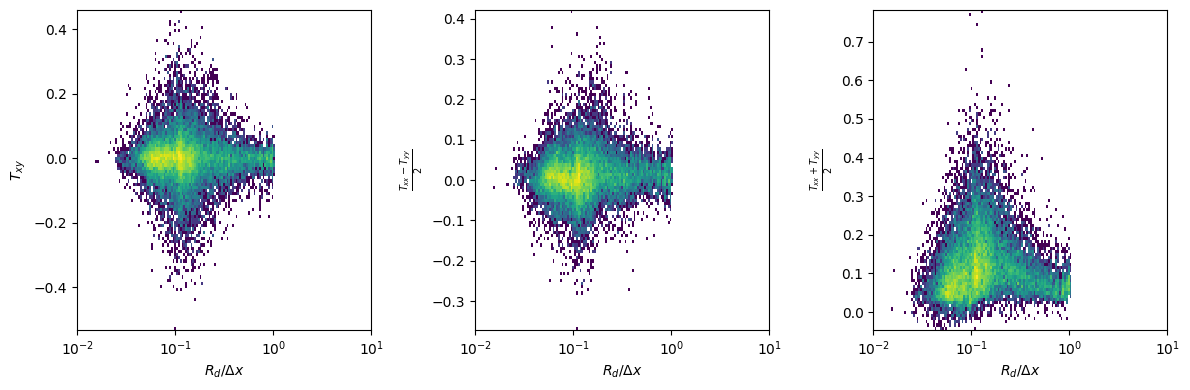

In [88]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.hist2d(features_log[:,-1], targets_log[:,0], bins=100, norm=mpl.colors.LogNorm());
plt.ylabel('$T_{xy}$')
plt.xlabel('$R_d/\Delta x$')
plt.xticks([-2,-1,0,1],['$10^{-2}$','$10^{-1}$', '$10^{0}$', '$10^{1}$'])

plt.subplot(1,3,2)
plt.hist2d(features_log[:,-1], (targets_log[:,1]-targets_log[:,2])*0.5, bins=100, norm=mpl.colors.LogNorm());
plt.ylabel('$\\frac{T_{xx}-T_{yy}}{2}$')
plt.xlabel('$R_d/\Delta x$')
plt.xticks([-2,-1,0,1],['$10^{-2}$','$10^{-1}$', '$10^{0}$', '$10^{1}$'])

plt.subplot(1,3,3)
plt.hist2d(features_log[:,-1], (targets_log[:,1]+targets_log[:,2])*0.5, bins=100, norm=mpl.colors.LogNorm());
plt.ylabel('$\\frac{T_{xx}+T_{yy}}{2}$')
plt.xlabel('$R_d/\Delta x$')
plt.xticks([-2,-1,0,1],['$10^{-2}$','$10^{-1}$', '$10^{0}$', '$10^{1}$'])

plt.tight_layout()

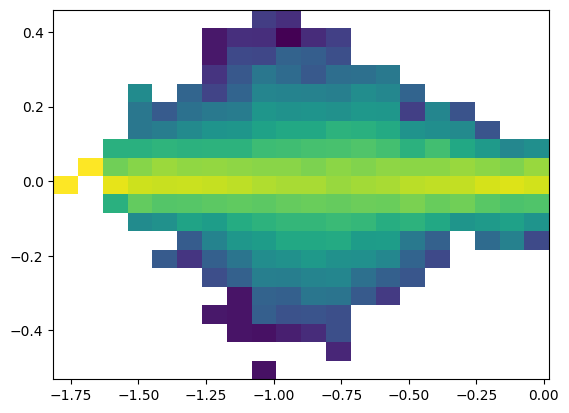

In [99]:
H, yedges, xedges = np.histogram2d(targets_log[:,0], features_log[:,-1], bins=[20,20])
# Conditioning
H = H / H.sum(0)
plt.pcolormesh(xedges, yedges, H, norm=mpl.colors.LogNorm())

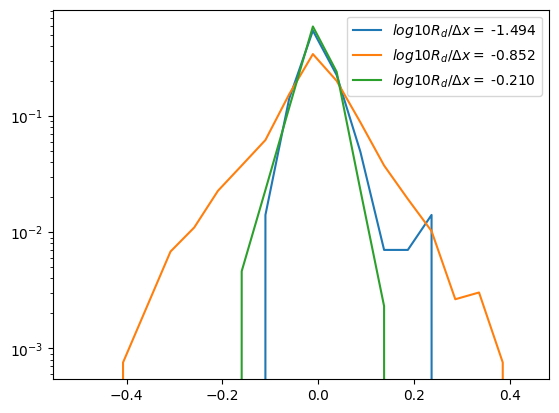

In [100]:
ycenters = (yedges[1:]+yedges[:-1])*0.5
xcenters = (xedges[1:]+xedges[:-1])*0.5
plt.semilogy(ycenters, H[:,3], label='$log10 R_d/\Delta x =$ %.3f' % xcenters[3])
plt.semilogy(ycenters, H[:,10], label='$log10 R_d/\Delta x =$ %.3f' % xcenters[10])
plt.semilogy(ycenters, H[:,17], label='$log10 R_d/\Delta x =$ %.3f' % xcenters[17])
plt.legend()

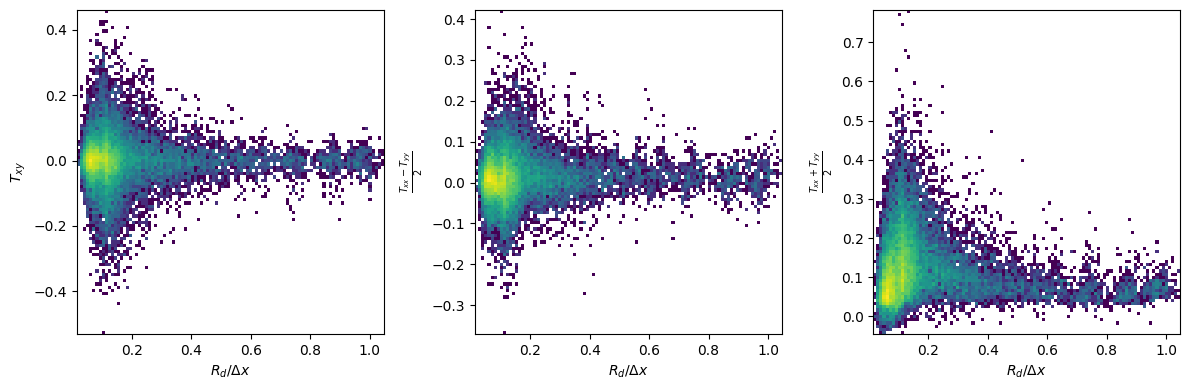

In [101]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.hist2d(10**(features_log[:,-1]), targets_log[:,0], bins=100, norm=mpl.colors.LogNorm());
plt.ylabel('$T_{xy}$')
plt.xlabel('$R_d/\Delta x$')

plt.subplot(1,3,2)
plt.hist2d(10**(features_log[:,-1]), (targets_log[:,1]-targets_log[:,2])*0.5, bins=100, norm=mpl.colors.LogNorm());
plt.ylabel('$\\frac{T_{xx}-T_{yy}}{2}$')
plt.xlabel('$R_d/\Delta x$')

plt.subplot(1,3,3)
plt.hist2d(10**(features_log[:,-1]), (targets_log[:,1]+targets_log[:,2])*0.5, bins=100, norm=mpl.colors.LogNorm());
plt.ylabel('$\\frac{T_{xx}+T_{yy}}{2}$')
plt.xlabel('$R_d/\Delta x$')

plt.tight_layout()

In [111]:
Tall_hd = import_ANN('/scratch/pp2681/mom6/CM26_ML_models/ocean3d/Gauss-FGR3/EXP-32-32/Held_Larichev_1996/model/Tall.nc')
pred_hd = ds['test-4'].select2d(zl=1,time=12).state.ANN(None,None,Tall_hd,feature_functions=[Held_Larichev_1996], gradient_features=['sh_xy', 'sh_xx', 'rel_vort'])

In [112]:
features_hd = pred_hd['feature_statistics']['features']
targets_hd = pred_hd['feature_statistics']['targets']

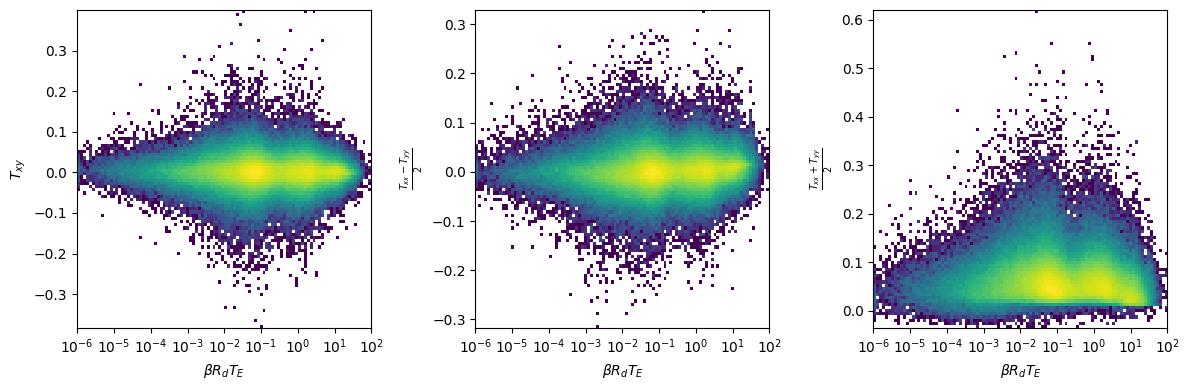

In [113]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.hist2d(features_hd[:,-1], targets_hd[:,0], bins=100, norm=mpl.colors.LogNorm());
plt.ylabel('$T_{xy}$')
plt.xlabel('$\\beta R_d T_{E}$')
plt.xticks([-6,-5,-4,-3,-2,-1,0,1,2],['$10^{-6}$','$10^{-5}$','$10^{-4}$','$10^{-3}$','$10^{-2}$','$10^{-1}$', '$10^{0}$', '$10^{1}$', '$10^{2}$'])

plt.subplot(1,3,2)
plt.hist2d(features_hd[:,-1], (targets_hd[:,1]-targets_hd[:,2])*0.5, bins=100, norm=mpl.colors.LogNorm());
plt.ylabel('$\\frac{T_{xx}-T_{yy}}{2}$')
plt.xlabel('$\\beta R_d T_{E}$')
plt.xticks([-6,-5,-4,-3,-2,-1,0,1,2],['$10^{-6}$','$10^{-5}$','$10^{-4}$','$10^{-3}$','$10^{-2}$','$10^{-1}$', '$10^{0}$', '$10^{1}$', '$10^{2}$'])

plt.subplot(1,3,3)
plt.hist2d(features_hd[:,-1], (targets_hd[:,1]+targets_hd[:,2])*0.5, bins=100, norm=mpl.colors.LogNorm());
plt.ylabel('$\\frac{T_{xx}+T_{yy}}{2}$')
plt.xlabel('$\\beta R_d T_{E}$')
plt.xticks([-6,-5,-4,-3,-2,-1,0,1,2],['$10^{-6}$','$10^{-5}$','$10^{-4}$','$10^{-3}$','$10^{-2}$','$10^{-1}$', '$10^{0}$', '$10^{1}$', '$10^{2}$'])

plt.tight_layout()

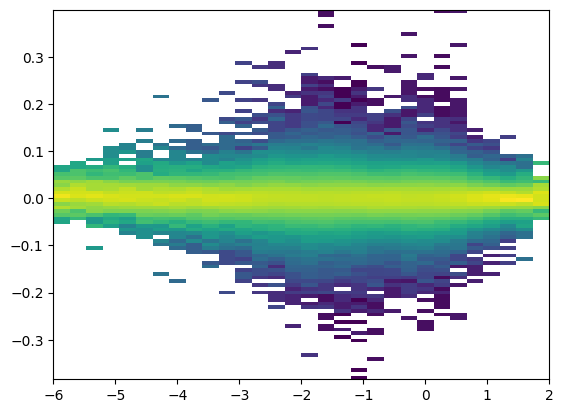

In [131]:
H, yedges, xedges = np.histogram2d(targets_hd[:,0], features_hd[:,-1], bins=[100,30])
# Conditioning
H = H / H.sum(0)
plt.pcolormesh(xedges, yedges, H, norm=mpl.colors.LogNorm())

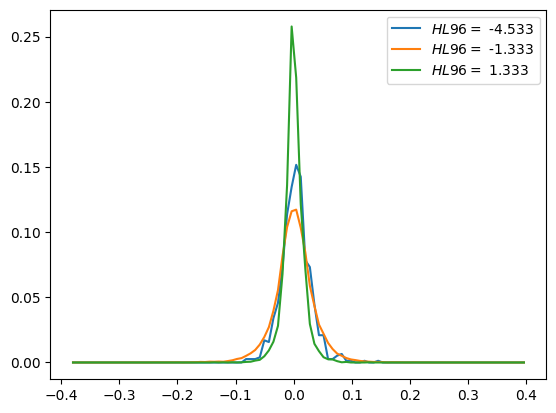

In [127]:
ycenters = (yedges[1:]+yedges[:-1])*0.5
xcenters = (xedges[1:]+xedges[:-1])*0.5
plt.semilogy(ycenters, H[:,5], label='$HL96 =$ %.3f' % xcenters[5])
plt.semilogy(ycenters, H[:,17], label='$HL96 =$ %.3f' % xcenters[17])
plt.semilogy(ycenters, H[:,27], label='$HL96 =$ %.3f' % xcenters[27])
plt.legend()
plt.yscale('linear')

In [136]:
sh_xy, sh_xx, vort_xy, div = ds['test-4'].state.velocity_gradients()

In [162]:
sh_xy_h = ds['test-4'].grid.interp(sh_xy,['X','Y'])

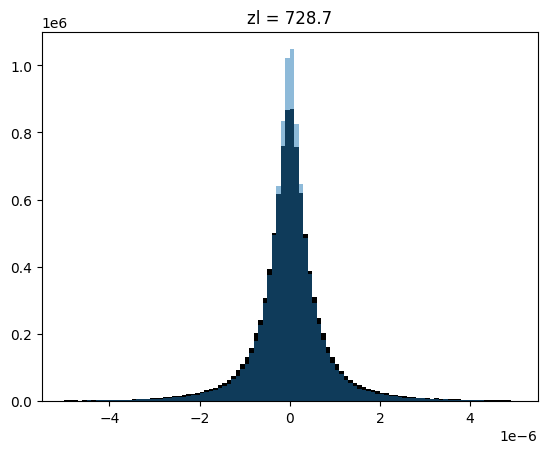

In [166]:
ds['test-4'].nanvar(sh_xy).isel(zl=5,time=12).plot.hist(bins=100,range=[-0.5e-5,0.5e-5],density=True,color='k');
ds['test-4'].nanvar(sh_xy_h).isel(zl=5,time=12).plot.hist(bins=100,range=[-0.5e-5,0.5e-5],alpha=0.5,density=True);
#ds['test-4'].nanvar(sh_xx).isel(zl=5,time=12).plot.hist(bins=100,range=[-0.5e-5,0.5e-5],alpha=0.5, density=True);

# Summary
* There is dependence of conditional PDFs of stress tensor on physical parameters. Mostly it is precence of fat tails
* Interpolated features have slightly different distribution
* Joint log-PDFs is a sufficient tool to analyze dependence of subgrid flux on physical parameters
* For every physical parameter we should understand typical value when the distribution has the fattest tails. This value should correspond to somewhat center of physical feature.

# What is the linmit for Hallberg 2013 feature in the testing datasets

In [34]:
ds = read_datasets(['test'], factors=[4,9,12,15])

Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-4
Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-9
Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-12
Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-15


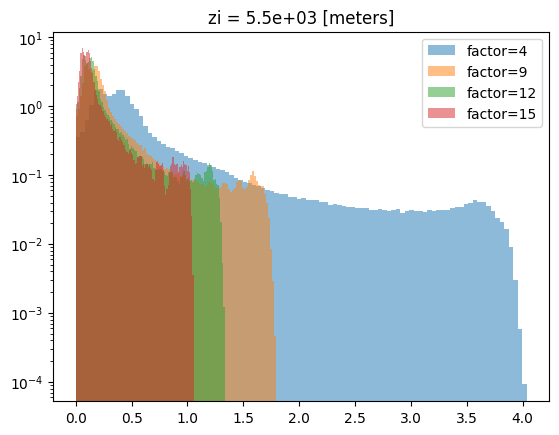

In [49]:
for factor in [4,9,12,15]:
    dds = ds['test-'+str(factor)]
    dx = np.sqrt(dds.param.dxT**2 + dds.param.dyT**2)
    Ld = dds.data.deformation_radius
    (dds.nanvar(Ld/dx)).plot.hist(bins=100, label=f'factor={factor}', alpha=0.5, density=True);
plt.legend()
plt.yscale('log')

In [50]:
# So, we should limit this input feature by 4